In [2]:
# Import Necessary Modules
import glob
import matplotlib.pyplot as plt
import math
from skimage import io
import numpy as np
%matplotlib inline 

In [3]:
#This function reads in all images in catsfolder/ and dogsfolder/. 
#Each 64 x 64 image is reshaped into a length-4096 row vector. 
#These row vectors are stacked on top of one another to get two data
#matrices, each with 4096 columns, with cats first, then dogs.  The
#function outputs this data matrix, along with a vector containing a
#label for each data point, with 0 for cats and 1 for dogs. 

def read_cats_dogs():
    # get image filenames
    cat_locs = glob.glob('catsfolder/*.jpg')
    dog_locs = glob.glob('dogsfolder/*.jpg')
    cat_locs.sort()
    dog_locs.sort()

    num_cats = len(cat_locs)
    num_dogs = len(dog_locs)

    # initialize empty arrays
    cats = np.zeros((num_cats,64*64))
    dogs = np.zeros((num_dogs,64*64))
    im = np.zeros(64*64,)

    #reshape images into row vectors and stack into a matrix 
    for i in range(num_cats):
        img = cat_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        cats[i,:] = im

    for i in range(num_dogs):
        img = dog_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        dogs[i,:] = im
    n0,d0 = cats.shape
    n1,d1 = dogs.shape

    if (n0 == 0) or (n1 == 0):
        raise Exception("you did not read in any data. The catsfolder and/or dogsfolder are not in this folder")

    if (d0 != d1):
        raise Exception("dataset0 and dataset1 do not have the same number of columns.")

    datamatrix = np.vstack((cats,dogs))
    labelvector = np.concatenate((np.zeros(n0),np.ones(n1)))

    return datamatrix, labelvector

In [4]:
#This function takes in an n x 4096 data matrix X and an index i. It extracts
#the ith row of X and displays it as a grayscale 64 x 64 image.

def show_image(X, i):
    #select image
    image = X[i,:]
    #reshape make into a square
    image = image.reshape((64,64))
    #display the image
    plt.imshow(image,'gray')

In [5]:
#Read in pet classificaton data 
X,Y = read_cats_dogs()
n,d = X.shape
n1 = Y.size

if (n != n1):
    raise Exception("Don't have same number of labels and data vectors")

#To speed up the script, load the cats and dogs dataset once.  Don't execute this cell every time. 

In [6]:
# 10.4(a)  Fill in this function

#This function takes in a data matrix X, corresponding vector 
#of labels Y, and a desired label. It outputs the the number 
#of samples with desiredlabel as n_label as well as the sample
#mean vector mu_label and sample covariance matrix sigma_label
#for the data in X whose labels in Y are equal to desired label.

def labeled_mean_cov(X,Y,desiredlabel):
    n,d = X.shape
    n_label = 0
    mu_label = np.zeros((0,d))
    sigma_label = np.zeros((0,d))
    
    # Your code here 
    row_count = 0
    for ii, row in enumerate(X):
        if Y[ii] == desiredlabel:
            n_label+=1
            mu_label = np.vstack([mu_label, row])
            sigma_label = np.vstack([sigma_label, row])
            #mu_label[row_count] = row
            #sigma_label[row_count] = row
            row_count+=1
    mu_label = np.mean(mu_label, axis=0)
    sigma_label = np.cov(sigma_label, rowvar=False)

    return n_label, mu_label, sigma_label

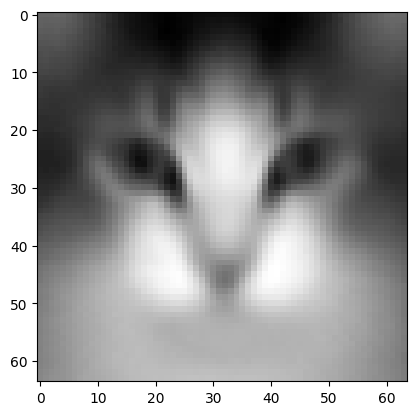

In [7]:
#10.4 (a)  Compute the average cat and get a picture, then compute the average and get a picture
# using the labeled_mean_cov function above.

n0,mu0,Sigma0 = labeled_mean_cov(X,Y,0)

# make the mu array into a row vector for printing
average_cat = np.reshape(mu0,(1,-1))
show_image(average_cat,0)

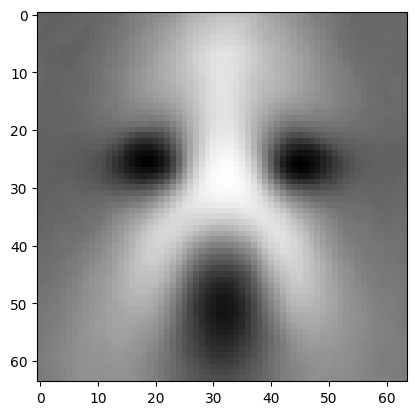

In [8]:
#10.4 (a)  Compute the average cat and get a picture, then compute the average dog and get a picture
# using the labeled_mean_cov function above.

n1,mu1,Sigma1 = labeled_mean_cov(X,Y,1)

# make the mu array into a row vector for printing
average_dog = np.reshape(mu1,(1,-1))
show_image(average_dog,0)

In [9]:
def error_rate(yguess,ytrue):
    if (yguess.shape == ytrue.shape):
        numguesses = yguess.size
    else:
        raise Exception("yguess and ytrue are not the same shape.  One may be a 1-D array, the other a 2-D array.")
    error_rate_value = 1/numguesses*np.sum(yguess != ytrue)
    return error_rate_value

In [10]:
# 10.4(b)  Extend the closest average function of HW 8 to take in a full data matrix X,
# with two averages, and classify each of the rows in this data matrix as 0 if mu0 is closer, 
# as 1 if mu1 is closer.  It outputs a vector guess contains the decision for each row of the data matrix.
# In the case of a tie, it outputs 1.

def closest_average(X,mu0,mu1):
    #Calculate distances.
    n,d = X.shape
    guess = np.zeros(n)
    
    # Your code here 
    for ii in range(n):
        dist_from_cat = np.linalg.norm(np.subtract(X[ii], mu0))
        dist_from_dog = np.linalg.norm(np.subtract(X[ii], mu1))
        if dist_from_cat < dist_from_dog:
            guess[ii] = 0
        else:
            guess[ii] = 1

    return guess

In [11]:
# 10.4(b) Compute the performance of the closest average classifier on the full data set

yguess = closest_average(X,mu0, mu1)
CAerrors = error_rate(yguess, Y)
print(yguess)
# LOOKING TO GET 0.197 ? LEFTOVER RESULT FROM NOTEBOOK
print(f'Error rate for closest average classifier is {CAerrors}')

[1. 1. 1. ... 1. 1. 0.]
Error rate for closest average classifier is 0.197


In [12]:
#10.4 (c) Complete the dimensionality_reduction function to take in a data matrix
# DataMatrix, and a number k of desired reduced dimensions.  It outputs a reduced dimension
# data matrix, with features corresponding to the features along the k largest principal 
# components of the covariance of the original data matrix. It first computes the eigenvectors
# and eigenvalues of the covariance of the data matrix. It selects the k eigenvectors corresponding to 
# the k largest eigenvalues (the principal components), centers the data by subtracting mu, and projects
# the centered data to k dimensions by multiplying by the matrix
# of k eigenvectors.

def dimensionality_reduction(Xrun,mu,V,D,k):
    n,d = Xrun.shape
    Xrun_reduced = np.zeros((n,k))

    ## Your code here
    indices = np.argsort(D)
    rindices = np.flip(indices)
    k_indices = []
    for ii in range(k):
        k_indices.append(rindices[ii])
    Vkd = V[:, k_indices]
    Xrun_reduced = np.subtract(Xrun,mu)@Vkd

    return Xrun_reduced

def visualize2d(dataset0,dataset1):
    """
    Reference function from Homework 7.
    """
    X = np.vstack((dataset0,dataset1))
    muX = np.mean(X, axis=0)
    sigmaX = np.cov(X, rowvar=False)
    D,V = np.linalg.eig(sigmaX)
    print(D)
    indices = np.argsort(D)  # find indices of eigenvalues in increasing order
    print(indices)
    rindices = np.flip(indices)  #reverse the indices so largest is first
    i = rindices[0]
    j = rindices[1]
    V2d = V[:,[i,j]]
    dataset0_2d = (dataset0 - muX)@V2d
    dataset1_2d = (dataset1 - muX)@V2d

    return dataset0_2d, dataset1_2d

In [13]:
mu = np.mean(X,axis=0)
sigma = np.cov(X, rowvar=False)
#Determine eigenvalues and eigenvectors.
D, V = np.linalg.eigh(sigma) 
Xreduced = dimensionality_reduction(X,mu,V,D,30)
print(Xreduced)

[[ 2.08137570e+02  1.17618819e+03 -1.12473344e+03 ... -3.65106544e+01
  -4.91772586e+01  1.42281435e+02]
 [ 2.14298846e+03  4.94406981e+02  2.22702111e+02 ... -3.07382861e+02
  -1.51075327e+02  1.53124447e+02]
 [-3.94069618e+03  1.64130197e+03 -6.55806232e+02 ...  1.46928385e-01
  -1.69323478e+01  1.01086787e+02]
 ...
 [ 1.49437467e+03  5.86428430e+02 -1.35176780e+03 ... -1.32074212e+02
  -6.61812235e+01 -5.68712893e+01]
 [ 4.42049273e+03  1.49965074e+03  3.69405927e+02 ...  1.45138874e+02
  -1.92669507e+02 -2.11069662e+02]
 [ 6.52577271e+02 -1.36429971e+03 -1.99034422e+03 ... -6.26042741e+01
  -6.02869078e+02 -3.71851721e+02]]


In [14]:
#10.4 (d) This function takes in a data matrix Xrun as well the mean vectors mu0, mu1 
#and the covariance matrices sigma0, sigma1 estimated from the training data
#and produces a vector guesses, corresponding to the ML rule for Gaussian vectors
#with different means and the same covariance matrix, which is referred to as 
#Linear Discriminant Analysis (LDA) in machine learning.

def LDA(Xrun,mu0,mu1,sigmapooled):
    n,d = Xrun.shape
    guesses = np.zeros(n)

    ## Your code here
    for ii, row in enumerate(Xrun):
        l = np.transpose(np.subtract(row,mu1)) @ np.linalg.inv(sigmapooled) @ np.subtract(row,mu1)
        r = np.transpose(np.subtract(row,mu0)) @ np.linalg.inv(sigmapooled) @ np.subtract(row,mu0)
        if l <= r:
            guesses[ii] = 1
        else:
            guesses[ii] = 0

    return guesses

In [15]:
n0,mu0,sigma0 = labeled_mean_cov(Xreduced,Y,0)
n1,mu1,sigma1 = labeled_mean_cov(Xreduced,Y,1)
sigmapooled = (1./(n0+n1-2))*((n0-1.)*sigma0 + (n1-1.)*sigma1)
yguess = LDA(Xreduced,mu0,mu1,sigmapooled)

LDAerrors = error_rate(yguess, Y)

print(f'Error rate for LDA classifier with 30 features is {LDAerrors}')

Error rate for LDA classifier with 30 features is 0.10400000000000001


In [16]:
#10.4 (e) This function takes in a data matrix Xrun as well the mean vectors mu0, mu1 
#and the covariance matrices sigma0, sigma1 estimated from the training data
#and produces a vector guesses, corresponding to the ML rule for Gaussian vectors
#with different means and different covariance matrices, which is referred to as 
#Quadratic Discriminant Analysis (QDA) in machine learning.

def QDA(Xrun,mu0,mu1,sigma0,sigma1):
    n,d = Xrun.shape
    guesses = np.zeros(n)

    # Your code here
    d0, v0 = np.linalg.eigh(sigma0)
    log_det_sigma0 = np.sum(np.log(d0))
    #print(log_det_sigma0)
    d1, v1 = np.linalg.eigh(sigma1)
    log_det_sigma1 = np.sum(np.log(d1))
    #print(log_det_sigma1)

    for ii, row in enumerate(Xrun):
        #l = np.log(np.linalg.det(sigma1)) + (np.transpose(np.subtract(row,mu1)) @ np.linalg.inv(sigma1) @ np.subtract(row,mu1))
        l = log_det_sigma1 + ((np.transpose(np.subtract(row,mu1)) @ np.linalg.inv(sigma1)) @ np.subtract(row,mu1))
        #r = np.log(np.linalg.det(sigma0)) + (np.transpose(np.subtract(row,mu0)) @ np.linalg.inv(sigma0) @ np.subtract(row,mu0))
        r = log_det_sigma0 + ((np.transpose(np.subtract(row,mu0)) @ np.linalg.inv(sigma0)) @ np.subtract(row,mu0))
        if l <= r:
            guesses[ii] = 1
        else:
            guesses[ii] = 0
    return guesses

In [17]:
yguess = QDA(Xreduced,mu0,mu1,sigma0,sigma1)

QDAerrors = error_rate(yguess, Y)

print(f'Error rate for QDA classifier with 30 features is {QDAerrors}')

Error rate for QDA classifier with 30 features is 0.043000000000000003


In [18]:
# 10.4(f)  This function takes in a data matrix Xrun as well a training data matrix Xtrain and
# the labels for the training data ytrain.  For each row of Xrun, it finds the closest row in Xtrain
# and assigns the label of that closest row as the guessed label for the row of Xtrain. 

def nearest_neighbor(Xrun,Xtrain,ytrain):
    n,d = Xrun.shape
    guesses = np.zeros(n)

    # Your code here
    for ii, row in enumerate(Xrun):
        abs_min = 100000 # large number to satisfy cond at least once
        for jj, train_row in enumerate(Xtrain):
            curr_min = np.linalg.norm(np.subtract(row,train_row))
            if curr_min < abs_min:
                abs_min = curr_min
                guesses[ii] = ytrain[jj]

    return guesses

In [19]:
n = Xreduced.shape[0]
permutation = np.random.permutation(n) # generates a permutation
Xshifted = Xreduced[permutation,:]
Yshifted = Y[permutation]

n1 = math.floor(0.8*n)

Xtrain = Xshifted[:n1,:]
Ytrain = Yshifted[:n1]
Xrun = Xshifted[n1:,:]
Yrun = Yshifted[n1:]
yguess = nearest_neighbor(Xrun,Xtrain,Ytrain)

NNerrors = error_rate(yguess, Yrun)

print(f'Error rate for NN classifier with 30 features is {QDAerrors}')

Error rate for NN classifier with 30 features is 0.043000000000000003


In [20]:
# 10.4 (g) -- Script for evaluationg overfitting
#Split the data into numfolds equal-sized segments
numfolds = 5
#All but one fold used for training
trainfraction = (numfolds-1)/numfolds 

#Dimensions to try for PCA dimensionality reduction
kvalues = np.array([10, 25, 50, 100, 250, 500])
numkvalues = kvalues.size

#Initialize arrays to store error rate estimates.
train_error_NN = np.zeros((numfolds,numkvalues))
test_error_NN = np.zeros((numfolds,numkvalues))
train_error_LDA = np.zeros((numfolds,numkvalues))
test_error_LDA = np.zeros((numfolds,numkvalues))
train_error_QDA = np.zeros((numfolds,numkvalues))
test_error_QDA = np.zeros((numfolds,numkvalues))

train_error_CA = np.zeros((numfolds,numkvalues))
test_error_CA = np.zeros((numfolds,numkvalues))

# randomly permutation of the full data set: ge the indices 
n = X.shape[0]
np.random.seed(42)
permutation = np.random.permutation(n) 

In [21]:
#Loop over folds, using the mth fold for testing, remainder for training.

for m in range(numfolds):
    print("Fold " + str(m+1) + " out of " + str(numfolds) + ".")

    permshift = np.roll(permutation,math.floor(n*m/numfolds))
    dataperm = X[permshift,:]
    labelperm = Y[permshift]
    #Split dataset into training and test data.
    n1 = math.floor(n*trainfraction)
    Xtrain = dataperm[0:n1,:]
    Xtest = dataperm[n1:,:]
    Ytrain = labelperm[0:n1]
    Ytest = labelperm[n1:]

    ntrain = Xtrain.shape[0]
    ntest = Xtest.shape[0]

    #Compute covariance and PCA only once 
    mu = np.mean(X,axis=0)
    sigma = np.cov(Xtrain, rowvar=False)
    #Determine eigenvalues and eigenvectors.
    D, V = np.linalg.eigh(sigma) 
    
    #Loop over different sizes of dimension k for dimensionality reduction
    for j in range(numkvalues):
        k = kvalues[j] #Dimensionality reduction parameter.
        print(f"Trying dimension {k}.")

        #Reduce training and testing data to k dimensions.
        Xtrain_reduced = dimensionality_reduction(Xtrain,mu,V,D,k)
        Xtest_reduced = dimensionality_reduction(Xtest,mu,V,D,k)

        #Determine number of samples, mean vector, 
        #and covariance matrix for each label.
        n0train,mu0,sigma0 = labeled_mean_cov(Xtrain_reduced,Ytrain,0)
        n1train,mu1,sigma1 = labeled_mean_cov(Xtrain_reduced,Ytrain,1) 

        # Using the closest average classifier, produce guesses for the training and testing data.
        trainguesses_CA = closest_average(Xtrain_reduced,mu0,mu1)
        testguesses_CA = closest_average(Xtest_reduced,mu0,mu1)
        train_error_CA[m,j] = error_rate(trainguesses_CA,Ytrain)
        test_error_CA[m,j] = error_rate(testguesses_CA,Ytest)

        # #Using the NearestNeighbor classifier, produce guesses for the training and testing data.
        trainguesses_NN  = nearest_neighbor(Xtrain_reduced,Xtrain_reduced,Ytrain)
        testguesses_NN  = nearest_neighbor(Xtest_reduced,Xtrain_reduced,Ytrain)

        #Store resulting NN error rates.
        train_error_NN[m,j] = error_rate(trainguesses_NN,Ytrain)
        test_error_NN[m,j] = error_rate(testguesses_NN,Ytest)
        
        #Using the LDA algorithm, produce guesses for the training and testing data
        sigmapooled = 1/(n0train+n1train-2)*((n0train-1)*sigma0+(n1train-1)*sigma1)
        trainguesses_LDA = LDA(Xtrain_reduced,mu0,mu1,sigmapooled)
        testguesses_LDA = LDA(Xtest_reduced,mu0,mu1,sigmapooled)
        
        #Store resulting LDA error rates.
        train_error_LDA[m,j] = error_rate(trainguesses_LDA,Ytrain)
        test_error_LDA[m,j] = error_rate(testguesses_LDA,Ytest)
        
        # #Using the QDA algorithm, produce guesses for the training and testing data.
        trainguesses_QDA = QDA(Xtrain_reduced,mu0,mu1,sigma0,sigma1)
        testguesses_QDA = QDA(Xtest_reduced,mu0,mu1,sigma0,sigma1)
        
        # #Store resulting QDA error rates.
        train_error_QDA[m,j] = error_rate(trainguesses_QDA,Ytrain)
        test_error_QDA[m,j] = error_rate(testguesses_QDA,Ytest)

Fold 1 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.
Fold 2 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.
Fold 3 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.
Fold 4 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.
Fold 5 out of 5.
Trying dimension 10.
Trying dimension 25.
Trying dimension 50.
Trying dimension 100.
Trying dimension 250.
Trying dimension 500.


In [22]:
#Determine average error rates over folds.

avg_train_error_NN = np.mean(train_error_NN,axis=0)
avg_test_error_NN = np.mean(test_error_NN,axis=0)
avg_train_error_LDA = np.mean(train_error_LDA,axis=0)
avg_test_error_LDA = np.mean(test_error_LDA,axis=0)
avg_train_error_QDA = np.mean(train_error_QDA,axis=0)
avg_test_error_QDA = np.mean(test_error_QDA,axis=0)
avg_train_error_CA = np.mean(train_error_CA,axis=0)
avg_test_error_CA = np.mean(test_error_CA,axis=0)

print(avg_test_error_CA)
print(avg_test_error_LDA)
print(avg_test_error_QDA)
print(avg_test_error_NN)

[0.205  0.199  0.1985 0.199  0.199  0.199 ]
[0.143  0.1135 0.086  0.08   0.0825 0.101 ]
[0.106  0.063  0.0555 0.051  0.05   0.1   ]
[0.144  0.129  0.1395 0.1525 0.165  0.1735]


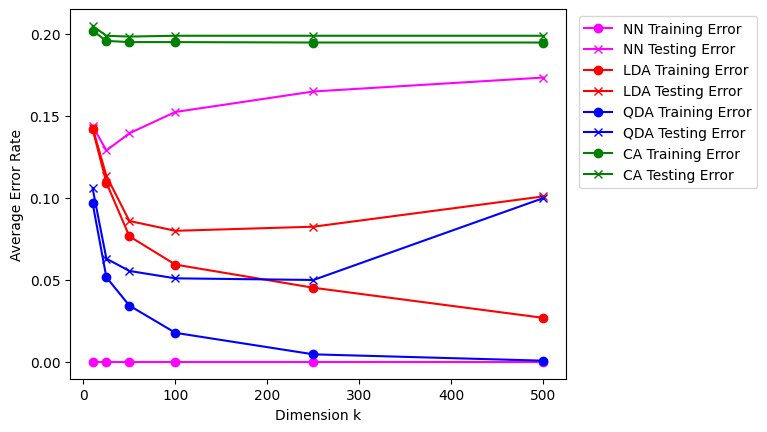

In [23]:
#Plot average error rates. 

fig = plt.figure()
plt.plot(kvalues,avg_train_error_NN,marker="o",color="magenta", label = 'NN Training Error')
plt.plot(kvalues,avg_test_error_NN,marker="x",color="magenta", label = 'NN Testing Error')
plt.plot(kvalues,avg_train_error_LDA,marker="o",color="red",label = 'LDA Training Error')
plt.plot(kvalues,avg_test_error_LDA,marker="x",color="red", label = 'LDA Testing Error')
plt.plot(kvalues,avg_train_error_QDA,marker="o",color="blue", label = 'QDA Training Error')
plt.plot(kvalues,avg_test_error_QDA,marker="x",color="blue", label = 'QDA Testing Error')
plt.plot(kvalues,avg_train_error_CA,marker="o",color="green", label = 'CA Training Error')
plt.plot(kvalues,avg_test_error_CA,marker="x",color="green", label = 'CA Testing Error')

plt.xlabel('Dimension k')
plt.ylabel('Average Error Rate')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

# plt.legend(['NN Training Error', 'NN Testing Error', 'LDA Training Error','LDA Testing Error','QDA Training Error','QDA Testing Error'])

plt.savefig("HW10plot.png")
plt.show()